필요한 모듈 임포트

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [ ]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [ ]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [ ]:
jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [ ]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [ ]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [ ]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [ ]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [ ]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [ ]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [ ]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [ ]:
jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [ ]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [ ]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [ ]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [ ]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [ ]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [ ]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [ ]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [ ]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [ ]:
jsb_data = jsb_data[:82064]

In [ ]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [ ]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [ ]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [ ]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:3]  + list(jsb_data.columns)[4:5] + list(jsb_data.columns)[6:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [ ]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [ ]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
전기전도도 μS/cm     9925
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [ ]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
전기전도도 μS/cm    0.120942
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [ ]:
len(jsb_data)

82064

In [ ]:
jsb_data.isnull().sum(axis = 1).value_counts()

0    53101
1    12689
7     6624
2     4201
3     3055
5     1168
4      671
6      555
dtype: int64

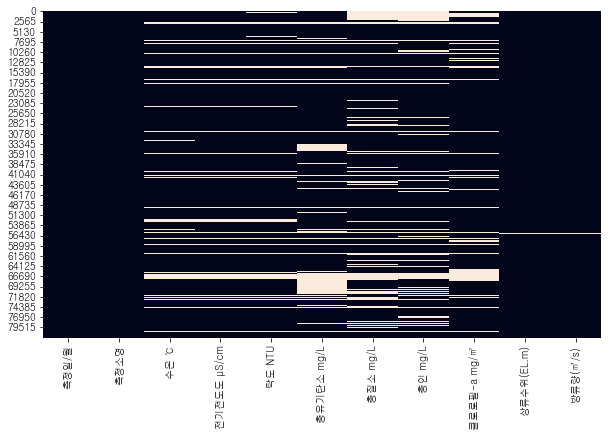

In [ ]:
sns.heatmap(jsb_data.isnull(), cbar=False)
plt.show()

시간데이터 추가

In [ ]:
jsb_df = jsb_data.copy()

In [ ]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [ ]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [ ]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [ ]:
for i in range(2, 24, 2):
    jsb_df[str(i) + 'shift 수온'] = jsb_df['수온 ℃'].shift(i)

In [ ]:
for i in range(24, 73, 6):
    jsb_df[str(i) + 'shift 수온'] = jsb_df['수온 ℃'].shift(i)

In [ ]:
len(jsb_df)

82064

In [ ]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       '2shift 수온', '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온',
       '12shift 수온', '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온',
       '22shift 수온', '24shift 수온', '30shift 수온', '36shift 수온', '42shift 수온',
       '48shift 수온', '54shift 수온', '60shift 수온', '66shift 수온', '72shift 수온'],
      dtype='object')

In [ ]:
len(jsb_df)

82064

결측치 보간법

In [ ]:
from datetime import datetime

In [ ]:
jsb_df = jsb_df.copy()

In [ ]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [ ]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time', limit = 12, limit_direction='both')

In [ ]:
jsb_df = jsb_df.dropna()

In [ ]:
jsb_df.__len__()

60515

In [ ]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온',
       '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온',
       '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온',
       '24shift 수온', '30shift 수온', '36shift 수온', '42shift 수온', '48shift 수온',
       '54shift 수온', '60shift 수온', '66shift 수온', '72shift 수온'],
      dtype='object')

In [ ]:
col = list(jsb_df.columns[2:])
print(col)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온', '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온', '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온', '24shift 수온', '30shift 수온', '36shift 수온', '42shift 수온', '48shift 수온', '54shift 수온', '60shift 수온', '66shift 수온', '72shift 수온']


In [ ]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온', '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온', '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온', '24shift 수온', '30shift 수온', '36shift 수온', '42shift 수온', '48shift 수온', '54shift 수온', '60shift 수온', '66shift 수온', '72shift 수온']


피처 정규화 없이

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [ ]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [ ]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [ ]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [ ]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.953823,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.953114,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.951349,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.949963,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.946315,5


In [ ]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [ ]:
estimator = gb_grid.best_estimator_

In [ ]:
pred = estimator.predict(X_test)

In [ ]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.11 전기전도도 μS/cm
0.13 탁도 NTU
0.2 총유기탄소 mg/L
0.07 총질소 mg/L
0.07 총인 mg/L
0.06 상류수위(EL.m)
0.03 방류량(㎥/s)
0.04 2shift 수온
0.01 4shift 수온
0.01 6shift 수온
0.0 8shift 수온
0.05 10shift 수온
0.01 12shift 수온
0.01 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.01 22shift 수온
0.01 24shift 수온
0.02 30shift 수온
0.01 36shift 수온
0.01 42shift 수온
0.01 48shift 수온
0.01 54shift 수온
0.06 60shift 수온
0.03 66shift 수온
0.04 72shift 수온


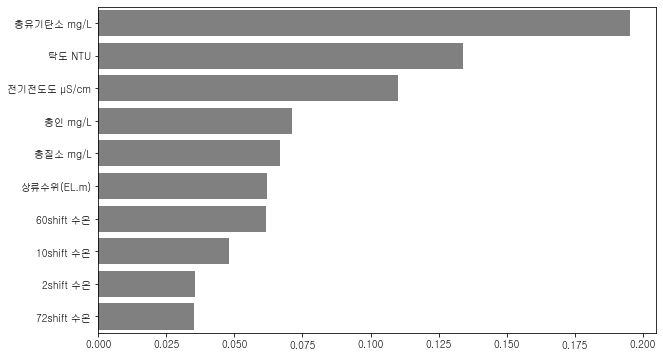

In [ ]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [ ]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9669191694374626


In [ ]:
feature_series[:10]

총유기탄소 mg/L     0.195148
탁도 NTU         0.133943
전기전도도 μS/cm    0.110161
총인 mg/L        0.071128
총질소 mg/L       0.066670
상류수위(EL.m)     0.062167
60shift 수온     0.061500
10shift 수온     0.048001
2shift 수온      0.035386
72shift 수온     0.035156
dtype: float64

피처 정규화

In [ ]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [ ]:
jsb_df_scaled.head()

,전기전도도 μS/cm,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),2shift 수온,4shift 수온,6shift 수온,...,22shift 수온,24shift 수온,30shift 수온,36shift 수온,42shift 수온,48shift 수온,54shift 수온,60shift 수온,66shift 수온,72shift 수온
0,-1.429396,-0.127603,-0.232501,-0.490408,1.08994,0.995722,-0.098141,-0.755099,-0.730179,-0.705265,...,-0.777785,-0.765211,-0.567499,-0.406861,-0.849508,-0.787489,-0.688228,-0.576553,-0.871628,-0.865044
1,-1.441404,-0.135119,-0.232501,-0.490408,1.08994,0.995722,-0.098141,-0.767398,-0.742478,-0.717565,...,-0.790083,-0.777510,-0.641303,-0.345354,-0.824904,-0.799795,-0.700538,-0.441132,-0.847005,-0.871200
2,-1.441404,-0.127603,-0.232501,-0.490408,1.08994,0.995722,-0.098141,-0.767398,-0.754778,-0.729864,...,-0.814680,-0.777510,-0.678206,-0.320751,-0.800300,-0.799795,-0.737465,-0.465754,-0.785449,-0.871200
3,-1.417388,-0.150150,-0.232501,-0.490408,1.08994,0.995722,-0.098141,-0.767398,-0.767077,-0.742164,...,-0.839277,-0.789809,-0.690507,-0.333053,-0.708034,-0.799795,-0.749774,-0.490376,-0.723892,-0.883514
4,-1.405380,-0.127603,-0.133532,-0.490408,1.08994,0.995722,-0.098141,-0.779697,-0.767077,-0.754464,...,-0.839277,-0.814407,-0.715108,-0.456067,-0.615769,-0.824406,-0.762084,-0.601175,-0.625401,-0.883514


In [ ]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [ ]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [ ]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [ ]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [ ]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.953738,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.953031,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.951373,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.949941,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.946346,5


In [ ]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [ ]:
estimators = gb_grids.best_estimator_

In [ ]:
preds = estimators.predict(X_tests)

In [ ]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.11 전기전도도 μS/cm
0.13 탁도 NTU
0.2 총유기탄소 mg/L
0.07 총질소 mg/L
0.07 총인 mg/L
0.06 상류수위(EL.m)
0.03 방류량(㎥/s)
0.04 2shift 수온
0.01 4shift 수온
0.01 6shift 수온
0.0 8shift 수온
0.05 10shift 수온
0.01 12shift 수온
0.01 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.01 22shift 수온
0.01 24shift 수온
0.02 30shift 수온
0.01 36shift 수온
0.01 42shift 수온
0.01 48shift 수온
0.01 54shift 수온
0.06 60shift 수온
0.03 66shift 수온
0.04 72shift 수온


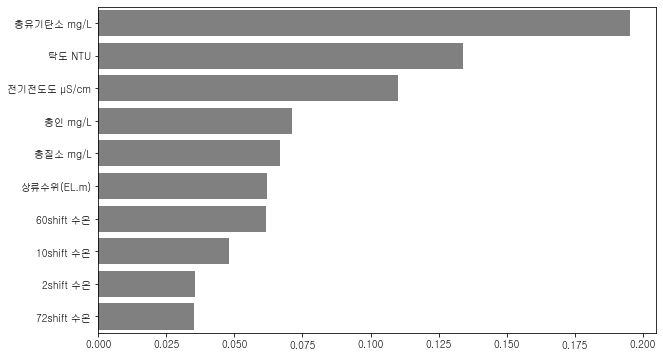

In [ ]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [ ]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9668357970274062


In [ ]:
feature_series[:10]

총유기탄소 mg/L     0.195148
탁도 NTU         0.133943
전기전도도 μS/cm    0.110161
총인 mg/L        0.071128
총질소 mg/L       0.066670
상류수위(EL.m)     0.062167
60shift 수온     0.061500
10shift 수온     0.048001
2shift 수온      0.035386
72shift 수온     0.035156
dtype: float64